# Titanic dataset - Dealing with imbalance data
## Effect of re-sampling in several ML algorithms

In [7]:
# Import required packages
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
#from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


In [8]:
# Read clean dataset
# Load clean dataframe resulting from the 'Titanic - Data Engineering.ipynb' file
df_train_clean = pd.read_csv(os.getcwd() + '\Clean_Titanic_train_dataframe.csv', na_values="?")
df_train_clean.head(10)

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,Age group,Ticket group,Accompanied,Companions,Fare group,FarePerPs,Age_data
0,1.0,0.0,3.0,1.0,22.0,5.0,7.2500,7.0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,3.62500,1.0
1,2.0,1.0,1.0,0.0,38.0,17599.0,71.2833,2.0,0.0,6.0,3.0,2.0,1.0,1.0,3.0,35.64165,1.0
2,3.0,1.0,3.0,0.0,26.0,2.0,7.9250,7.0,2.0,4.0,2.0,1.0,0.0,0.0,1.0,7.92500,1.0
3,4.0,1.0,1.0,0.0,35.0,113803.0,53.1000,2.0,2.0,6.0,3.0,4.0,1.0,1.0,3.0,26.55000,1.0
4,5.0,0.0,3.0,1.0,35.0,373450.0,8.0500,7.0,2.0,5.0,3.0,5.0,0.0,0.0,1.0,8.05000,1.0
5,6.0,0.0,3.0,1.0,27.0,330877.0,8.4583,7.0,1.0,5.0,2.0,5.0,0.0,0.0,1.0,8.45830,0.0
6,7.0,0.0,1.0,1.0,54.0,17463.0,51.8625,4.0,2.0,5.0,3.0,2.0,0.0,0.0,3.0,51.86250,1.0
7,8.0,0.0,3.0,1.0,2.0,349909.0,21.0750,7.0,2.0,3.0,1.0,5.0,1.0,4.0,2.0,4.21500,1.0
8,9.0,1.0,3.0,0.0,27.0,347742.0,11.1333,7.0,2.0,6.0,2.0,5.0,1.0,2.0,1.0,3.71110,1.0
9,10.0,1.0,2.0,0.0,14.0,237736.0,30.0708,7.0,0.0,6.0,1.0,4.0,1.0,1.0,2.0,15.03540,1.0


In [9]:
# Segregate target from features 
X = df_train_clean.drop(['PassengerId','Survived'], axis=1).copy()
y = df_train_clean['Survived'].copy()

In [10]:
# Normalise data
def NormaliseInputData(X):
    min_max_scaler = preprocessing.MinMaxScaler()
    return min_max_scaler.fit_transform(X)

X = NormaliseInputData(X)

In [11]:
# Evaluation function
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

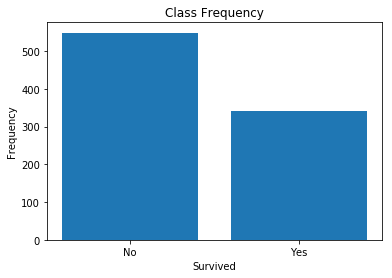

0.0    61.616162
1.0    38.383838
Name: Survived, dtype: float64

In [12]:
# Look at class balance
unique, counts = np.unique(y, return_counts=True)

plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Survived')
plt.ylabel('Frequency')
plt.xticks([0,1],['No','Yes'])
plt.show()

100*y.value_counts()/len(y)

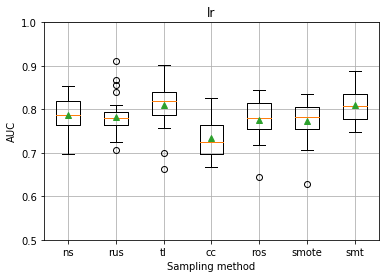

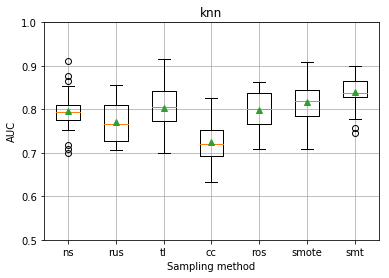

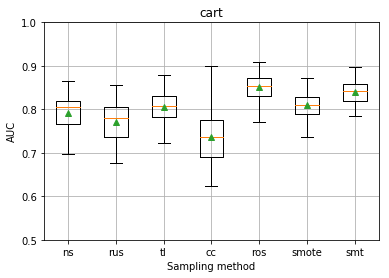

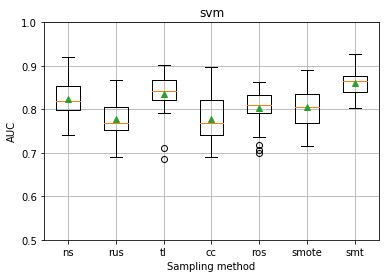

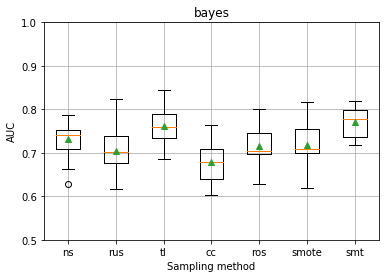

In [13]:
# Import Re-sampling libraries and functions
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    return models

# Get a list of sampling methods
def get_sampling_methods():
    sampling_method = dict()
    sampling_method['rus'] = RandomUnderSampler(return_indices=True)
    sampling_method['tl'] = TomekLinks(return_indices=True, ratio='majority')
    sampling_method['cc'] = ClusterCentroids(ratio={0: y.value_counts()[1]})
    sampling_method['ros'] = RandomOverSampler(return_indices=True)
    sampling_method['smote'] = SMOTE(ratio='minority')
    sampling_method['smt'] = SMOTETomek(ratio='auto')
    return sampling_method

# Plot model performance in boxplots showing the distribution of results given by the different data folds
def showboxplot(results, names, model_name):
    plt.boxplot(results, labels=names, showmeans=True)
    plt.ylim(0.5,1)
    plt.ylabel('AUC')
    plt.xlabel('Sampling method')
    plt.title(model_name)
    plt.grid()
    plt.show()

# Evaluate each model and the effect of a re-sampling method    
def evaluate_sampling_method_effect(model, model_name):
    # Evaluate model with no sampling
    results, names = list(), list()
    results.append(evaluate_model(model, X, y))
    names.append('ns')

    sampling_method = get_sampling_methods()
    
    for name, method in sampling_method.items():
        if name in ['rus','tl','ros']:
            Xsp, ysp, idx = method.fit_sample(X, y)
        else:
            Xsp, ysp = method.fit_sample(X, y)        
        results.append(evaluate_model(model, Xsp, ysp))
        names.append(name)

    showboxplot(results, names, model_name)

# Test each model for each re-sampling method
models = get_models()    
for model_name, model in models.items():
    evaluate_sampling_method_effect(model, model_name)    

    
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Conclusions:
* Several re-sampling methods have been used to provide a dataset with balanced classification
* The metric AUC has been choosen to better represent the goodness of the models in both binary classes
* The re-sampling methods have different effect depending on the ML model used
* Two ML models have shown a significant improvement of AUC when re-samplin is applied, specially over-ssampling. These are the KNeighborsClassifier and the DecisionTreeClassifier. In both cases the best balancing solution has been SMOTETomek: Over-sampling followed by under-sampling